In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%run ../modules/plotting_metrics.py

In [2]:
from memoization import cached


In [3]:
# Hold-out and Cross Validation

In [4]:
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

In [5]:
def plot_swarm_metrics(df_results, metric_name):
    sns.set(context='talk', style='whitegrid', font_scale=0.8)
    
    df_melted = pd.melt(df_results.loc[metric_name], var_name='method', value_name=metric_name)

    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.swarmplot(data=df_melted, x='method', y=metric_name,
                      size=6)
    sns.pointplot(data=df_melted, x='method', y=metric_name, dodge=True,
                  ci=95, ax=ax, join=False, color='black', capsize=0.4)
    ax.set(
           xlabel='VS Method')
    ax.set_title(f'ML vs CS results: {metric_name.replace("_", " ").upper()}', 
                 fontweight='bold', fontsize=18)


In [6]:
# Pandas styler
def _col_sig_p_values(val):
    color = 'red' if val < 0.05 else 'none'
    return 'color: %s' % color

## Classifiers and consensus Scorings
### ML Classifiers

In [7]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [8]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [9]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [10]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [11]:
from sklearn.ensemble import RandomForestClassifier

hyparams = {'n_estimators': 100, 'min_samples_split': 10,
            'min_samples_leaf': 4, 
            'max_features': 'sqrt', 'max_depth': 10}
rf = RandomForestClassifier(**hyparams)

In [12]:
# ML Classifier
ml_classifiers = {
    'dclf': dclf,
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'rf': rf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [13]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score,
    'RANK': get_rank_score 
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

## Estimators dictionary

In [14]:
estimators = {**ml_classifiers, **cs_functions}

# Cross Validation

In [15]:
%run ./1_Helper_functions.ipynb

In [16]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_005 = {'metric_name': 'ef', 
                    'fraction': 0.005, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'}
            )

### 5 folds/reps

In [18]:
%%time
cv5 = k_cross_validation(estimators, X, y, 
                             metrics=metrics,
                             n_splits=5, random_state=42)

metric='roc_auc'
# Normality
display(multi_norm_test(cv5, metric=metric))
# Homocedasticity
display(multi_homovar_test(cv5, metric=metric))

cv5.loc[metric]

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.126863,0.998071


CPU times: user 57.6 ms, sys: 143 µs, total: 57.7 ms
Wall time: 56.2 ms


,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
0,0.50653,0.79516,0.88112,0.92751,0.87512,0.64234,0.64502,0.57160,0.62889,0.64197
1,0.52860,0.78846,0.86721,0.88513,0.81211,0.60090,0.62607,0.54079,0.60534,0.59789
2,0.49467,0.81858,0.91357,0.91118,0.85323,0.65380,0.67037,0.58591,0.64147,0.65064
3,0.48893,0.80517,0.89885,0.90776,0.86725,0.63146,0.63170,0.54574,0.63917,0.62874
4,0.48209,0.78136,0.91855,0.93413,0.86544,0.65086,0.64554,0.57859,0.62882,0.64914


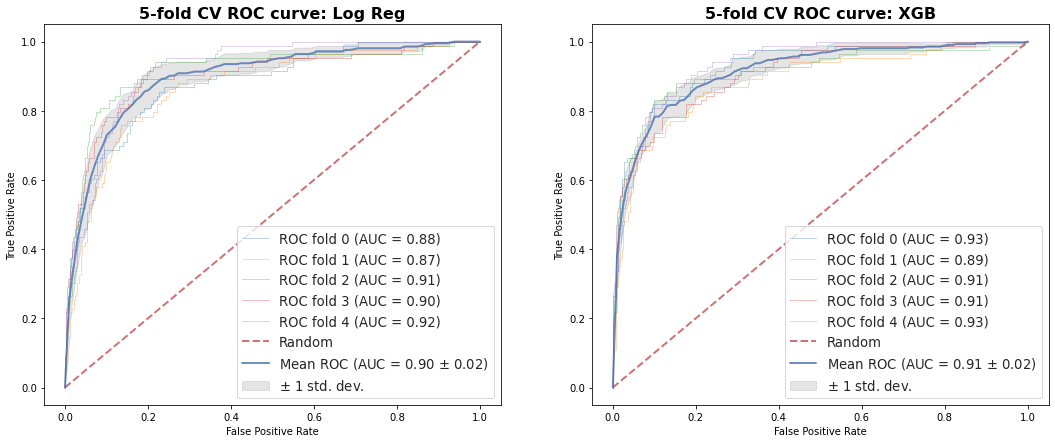

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
plot_roc_cv(lr, X, y, name='Log Reg', ax=ax[0], random_state=42)
plot_roc_cv(xgb, X, y, name='XGB', ax=ax[1], random_state=42)
plt.show()

## Hold-out validation

In [19]:
%%time
ho5 = n_hold_out_validation(estimators, X, y, metrics=metrics, 
                      n_reps=5, random_state=42)
metric='roc_auc'
# Normality
display(multi_norm_test(ho5, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho5, metric=metric))

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,0,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.339467,0.987126


CPU times: user 3min 37s, sys: 17.8 s, total: 3min 55s
Wall time: 48.1 s


### 15 folds/reps

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,0,1,1,1,1,1,1


,statistic,p
Bartlett,7.230976,0.925441


CPU times: user 35min 30s, sys: 1min 44s, total: 37min 14s
Wall time: 10min 24s


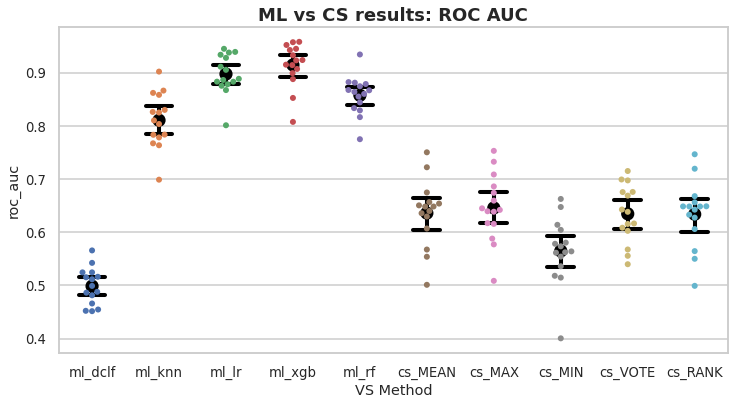

In [20]:
%%time
cv15 = k_cross_validation(estimators, X, y, 
                             metrics=metrics,
                             n_splits=15, random_state=42)

metric='roc_auc'
plot_swarm_metrics(cv15, metric_name=metric)
# Normality
display(multi_norm_test(cv15, metric=metric))
# Homocedasticity
display(multi_homovar_test(cv15, metric=metric))

/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.677887,1.0


CPU times: user 45min 49s, sys: 1min 12s, total: 47min 1s
Wall time: 15min 42s


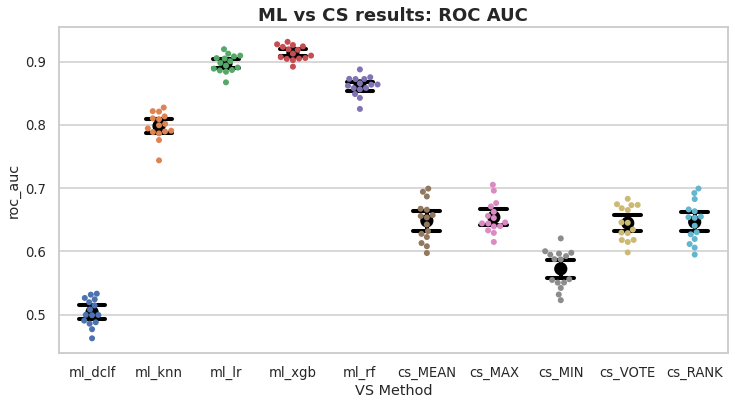

In [21]:
%%time
ho15 = n_hold_out_validation(estimators, X, y, metrics=metrics, 
                      n_reps=15, random_state=42)

metric='roc_auc'
plot_swarm_metrics(ho15, metric_name=metric)
# Normality
display(multi_norm_test(ho15, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho15, metric=metric))

### 5x2 CV

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.130247,1.0


CPU times: user 26min 20s, sys: 39.2 s, total: 26min 59s
Wall time: 7min 52s


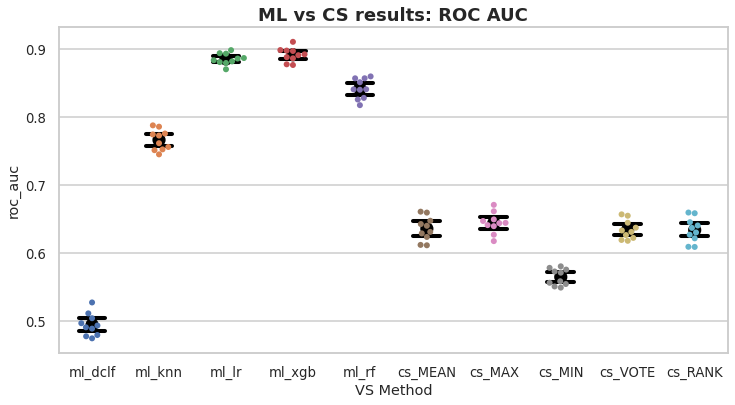

In [22]:
%%time
cv5x2 = nk_rep_cross_validation(estimators, X, y, metrics=metrics, 
                      n_splits=2, n_repeats=5, random_state=42)

metric='roc_auc'
plot_swarm_metrics(cv5x2, metric_name=metric)
# Normality
display(multi_norm_test(cv5x2))
# Homocedasticity
display(multi_homovar_test(cv5x2))

### 10x2 CV

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.130247,1.0


CPU times: user 26min 20s, sys: 39.2 s, total: 26min 59s
Wall time: 7min 52s


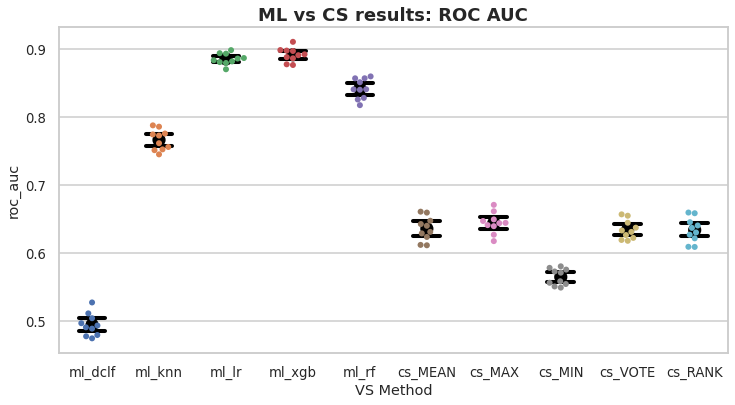

In [22]:
%%time
cv5x2 = nk_rep_cross_validation(estimators, X, y, metrics=metrics, 
                      n_splits=2, n_repeats=5, random_state=42)

metric='roc_auc'
plot_swarm_metrics(cv5x2, metric_name=metric)
# Normality
display(multi_norm_test(cv5x2))
# Homocedasticity
display(multi_homovar_test(cv5x2))

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,0.921509,0.999598


CPU times: user 1.28 s, sys: 108 ms, total: 1.39 s
Wall time: 1.21 s


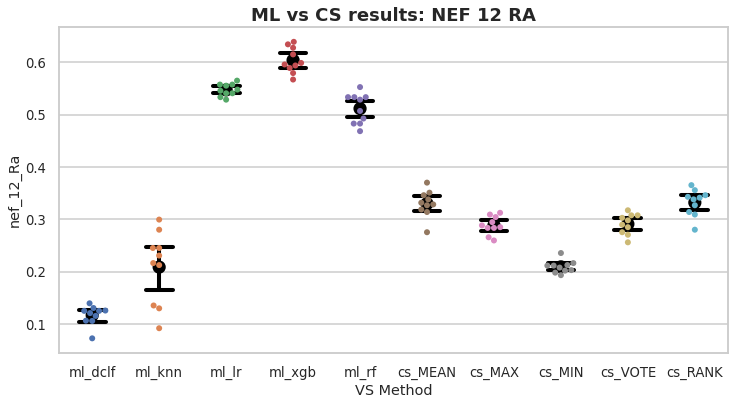

In [23]:
%%time
cv5x2 = nk_rep_cross_validation(estimators, X, y, metrics=metrics, 
                      n_splits=2, n_repeats=5, random_state=42)

metric='nef_12_Ra'
plot_swarm_metrics(cv5x2, metric_name=metric)
# Normality
display(multi_norm_test(cv5x2, metric=metric))
# Homocedasticity
display(multi_homovar_test(cv5x2, metric=metric))

## Multiple samples
- one-way ANOVA with repeated measures
- Friedman's ANOVA
- Cochran's Q test
- Binomial $\chi^2$ with Bonferroni correction

### one-way ANOVA with repeated measures

$H_0$: $\mu_1 = \mu_2 = ... = \mu_m$   
$H_a$: $\mu_i \neq \mu_j$, for at least one pair $i,j$ of the methods.

##### post hoc Tucket HSD
$H_0$: $\mu_i = \mu_j, \forall i \neq j$   
$H_a$: $\mu_i \neq \mu_j,  \forall i \neq j$


In [29]:
import statsmodels
from statsmodels.stats.anova import AnovaRM
from statsmodels import stats
from scipy.stats import f_oneway

In [30]:
df = cv5x2.loc['roc_auc']
df = df.drop('ml_dclf', axis=1)
n, m = df.shape

f = pd.melt(df, var_name='clf', value_name='score')
f['rep'] = np.tile(range(1, n + 1), m)


print(AnovaRM(data=f, depvar='score', subject='rep', within=['clf'], aggregate_func='mean').fit())

print(stats.multicomp.pairwise_tukeyhsd(endog=f['score'], groups=f['clf'], alpha=0.5))

               Anova
     F Value  Num DF  Den DF Pr > F
-----------------------------------
clf 1474.5861 8.0000 72.0000 0.0000



AttributeError: module 'statsmodels.stats' has no attribute 'multicomp'

In [31]:
f_oneway(*df.values.T)

F_onewayResult(statistic=778.9244574540766, pvalue=2.993189297928644e-73)

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols('score ~ C(clf) + C(rep)', data=f).fit()
# print(lm.summary())
table = sm.stats.anova_lm(lm, typ=2) 
table

,sum_sq,df,F,PR(>F)
C(clf),1.252779,8.0,1474.586094,1.376122e-76
C(rep),0.008638,9.0,9.037949,5.327423e-09
Residual,0.007646,72.0,NaN,NaN


### Non-parametric: Friedman's ANOVA for repeated measures

In [33]:
from scipy.stats import friedmanchisquare

friedmanchisquare(*df.values.T)

FriedmanchisquareResult(statistic=76.10666666666668, pvalue=2.9603179818747656e-13)

### post hocs

#### Wilcoxon

In [34]:
import scikit_posthocs as sp

sp.posthoc_conover(f, val_col='score', group_col='clf').style.applymap(_col_sig_p_values)

,cs_MAX,cs_MEAN,cs_MIN,cs_RANK,cs_VOTE,ml_knn,ml_lr,ml_rf,ml_xgb
cs_MAX,1.000000,0.143361,0.000000,0.054309,0.054309,0.000001,0.000000,0.000000,0.000000
cs_MEAN,0.143361,1.000000,0.000000,0.636078,0.636078,0.000000,0.000000,0.000000,0.000000
cs_MIN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cs_RANK,0.054309,0.636078,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
cs_VOTE,0.054309,0.636078,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
ml_knn,0.000001,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.009976,0.000000
ml_lr,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000736,0.372278
ml_rf,0.000000,0.000000,0.000000,0.000000,0.000000,0.009976,0.000736,1.000000,0.000032
ml_xgb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372278,0.000032,1.000000


#### Nemenyi

In [35]:
sp.posthoc_nemenyi_friedman(df).style.applymap(_col_sig_p_values)

,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
ml_knn,1.000000,0.611110,0.405206,0.900000,0.710204,0.900000,0.001473,0.180790,0.149525
ml_lr,0.611110,1.000000,0.900000,0.900000,0.009917,0.063491,0.001000,0.001000,0.001000
ml_xgb,0.405206,0.900000,1.000000,0.900000,0.002867,0.023112,0.001000,0.001000,0.001000
ml_rf,0.900000,0.900000,0.900000,1.000000,0.216940,0.561564,0.001000,0.017589,0.013263
cs_MEAN,0.710204,0.009917,0.002867,0.216940,1.000000,0.900000,0.301968,0.900000,0.900000
cs_MAX,0.900000,0.063491,0.023112,0.561564,0.900000,1.000000,0.079975,0.858844,0.809296
cs_MIN,0.001473,0.001000,0.001000,0.001000,0.301968,0.079975,1.000000,0.858844,0.900000
cs_VOTE,0.180790,0.001000,0.001000,0.017589,0.900000,0.858844,0.858844,1.000000,0.900000
cs_RANK,0.149525,0.001000,0.001000,0.013263,0.900000,0.809296,0.900000,0.900000,1.000000


### Two Samples
- Delong
- Nedeau
- Wilcoxon
- Bootstrap
- paired t-test
- McNemar
- 5x2cv F modified

In [ ]:
xgb_res = ho15.loc['roc_auc','ml_xgb']
knn_res = ho15.loc['roc_auc','ml_knn']

# Normalidad
norm_test(xgb_res)
norm_test(knn_res)

# Homogeneidad de varianzas
homovar_test(xgb_res, knn_res)

In [ ]:
%%time
from mlxtend.evaluate import combined_ftest_5x2cv

f, p = combined_ftest_5x2cv(
        estimator1=estimators['ml_xgb'],
        estimator2=estimators['ml_knn'],
        X=X, y=y,
        scoring='roc_auc',
        random_seed=42
    )

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

In [ ]:
f, p = combined_ftest_5x2cv(
        estimator1=estimators['ml_xgb'],
        estimator2=estimators['ml_lr'],
        X=X, y=y,
        scoring='roc_auc',
        random_seed=42
    )

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

In [ ]:
def standard_error(x):
    return np.std(x)/np.sqrt(len(x) - 1)

standard_error(cv15.loc['roc_auc','ml_xgb'])

In [ ]:
import numpy as np
from scipy import stats

def mean_confidence_interval(x, confidence=0.95):
    n = len(x)
    mean, se = np.mean(x), stats.sem(x)
    d = se * stats.t.ppf((1 + confidence)/2, n - 1)
    return mean - d, mean + d

a = cv15.loc['roc_auc','ml_xgb']
mean_confidence_interval(a)

sns.tsplot(a)

In [ ]:
import numpy as np, scipy.stats as st

st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))